# Download data

In [ ]:
# !gdown 1LMIaOY8NSKWmGtbvTsjXcHVaYKnNN_9u -O hw1_data.zip

In [ ]:
%cd ..

/content


In [ ]:
# !mkdir hw1_data
!unzip ./drive/MyDrive/DLCV/hw1_data.zip -d hw1_data

串流輸出內容已截斷至最後 5000 行。
 extracting: hw1_data/hw1_data/p1_data/train_50/20_245.png  
 extracting: hw1_data/hw1_data/p1_data/train_50/20_47.png  
 extracting: hw1_data/hw1_data/p1_data/train_50/47_381.png  
 extracting: hw1_data/hw1_data/p1_data/train_50/40_113.png  
 extracting: hw1_data/hw1_data/p1_data/train_50/3_13.png  
 extracting: hw1_data/hw1_data/p1_data/train_50/32_181.png  
 extracting: hw1_data/hw1_data/p1_data/train_50/43_320.png  
 extracting: hw1_data/hw1_data/p1_data/train_50/0_247.png  
 extracting: hw1_data/hw1_data/p1_data/train_50/17_64.png  
 extracting: hw1_data/hw1_data/p1_data/train_50/18_327.png  
 extracting: hw1_data/hw1_data/p1_data/train_50/24_153.png  
 extracting: hw1_data/hw1_data/p1_data/train_50/4_338.png  
 extracting: hw1_data/hw1_data/p1_data/train_50/48_91.png  
 extracting: hw1_data/hw1_data/p1_data/train_50/32_29.png  
 extracting: hw1_data/hw1_data/p1_data/train_50/23_57.png  
 extracting: hw1_data/hw1_data/p1_data/train_50/17_74.png  
 extracting: 

# Import


In [ ]:
!nvidia-smi

Mon Oct 10 02:20:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
import matplotlib.pyplot as plt
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [ ]:
# %cd drive/MyDrive/DLCV
# !ls

myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Prepare dataset


In [ ]:
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    
    
    transforms.RandomApply(transforms=[transforms.RandomHorizontalFlip(), transforms.RandomResizedCrop(size=(128, 128))], p = 0.9),
    transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.2, hue=0.1), transforms.RandomEqualize(), transforms.RandomSolarize(threshold=100.0)], p = 0.4),
    transforms.ToTensor(),
])

In [ ]:
class Dataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(Dataset).__init__()
        self.path = path

        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".png")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im,label

One ./hw1_data/hw1_data/p1_data/train_50 sample ./hw1_data/hw1_data/p1_data/train_50/0_0.png
One ./hw1_data/hw1_data/p1_data/val_50 sample ./hw1_data/hw1_data/p1_data/val_50/0_450.png


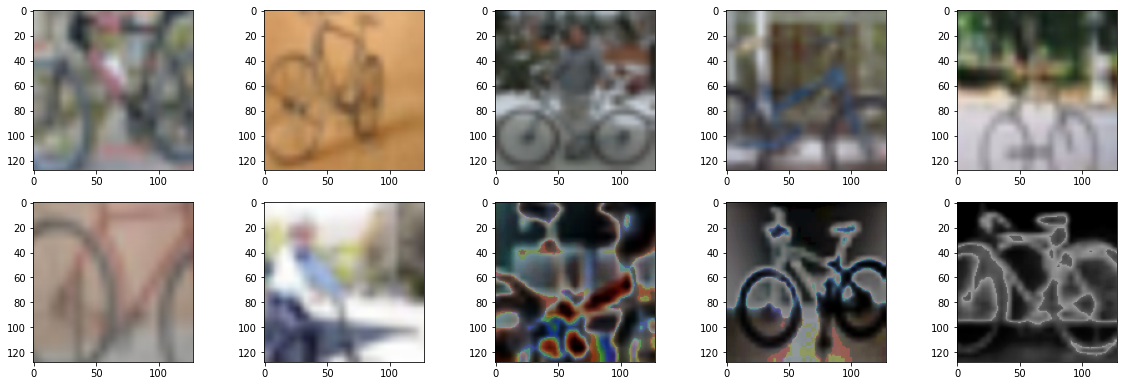

In [ ]:
batch_size = 32
_dataset_dir = "./hw1_data/hw1_data/p1_data"
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
def show_images(images, figsize=(20,10), columns = 5):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(image.permute(1, 2, 0))

# show some train data
train_set = Dataset(os.path.join(_dataset_dir,"train_50"), tfm=train_tfm)
img = []
for i in range(10):
  img.append(train_set.__getitem__(i+100)[0])
show_images(img)


train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = Dataset(os.path.join(_dataset_dir,"val_50"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input : [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 50)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Classifier().to(device)

In [ ]:
# "cuda" only when GPUs are available.

# The number of training epochs and patience.
n_epochs = 100
patience = 30 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.
# model = models.vgg16_bn(pretrained=False).to(device)
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5) 

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))
        # print(np.shape(logits))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "scratch.pt")
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break
    if epoch == 0 or epoch == 99 or epoch == 50:
        torch.save(model.state_dict(), f"{_exp_name}_best_{epoch}.ckpt") # only save best to prevent output memory exceed error

# 0.71400 -> best

In [ ]:
# reference:https://stackoverflow.com/questions/42697933/colormap-with-maximum-distinguishable-colours
import math

import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

def generate_colormap(number_of_distinct_colors: int = 50):
    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

    # Create an array with uniformly drawn floats taken from <0, 1) partition
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

    # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
    #     but each saw tooth is slightly higher than the one before
    # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]

    # Flatten the above matrix - join each row into single array
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

    # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
    initial_cm = hsv(nums_distributed_like_rising_saw)

    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half

    # Modify lower half in such way that colours towards beginning of partition are darker
    # First colours are affected more, colours closer to the middle are affected less
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm)

In [ ]:
!nvidia-smi

Tue Oct  4 17:14:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |   1838MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.decomposition import PCA
import seaborn as sns

activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

  0%|          | 0/79 [00:00<?, ?it/s]

Size of the dataframe: (2500, 8192)


  0%|          | 0/79 [00:00<?, ?it/s]

Size of the dataframe: (2500, 8192)


  0%|          | 0/79 [00:00<?, ?it/s]

Size of the dataframe: (2500, 8192)


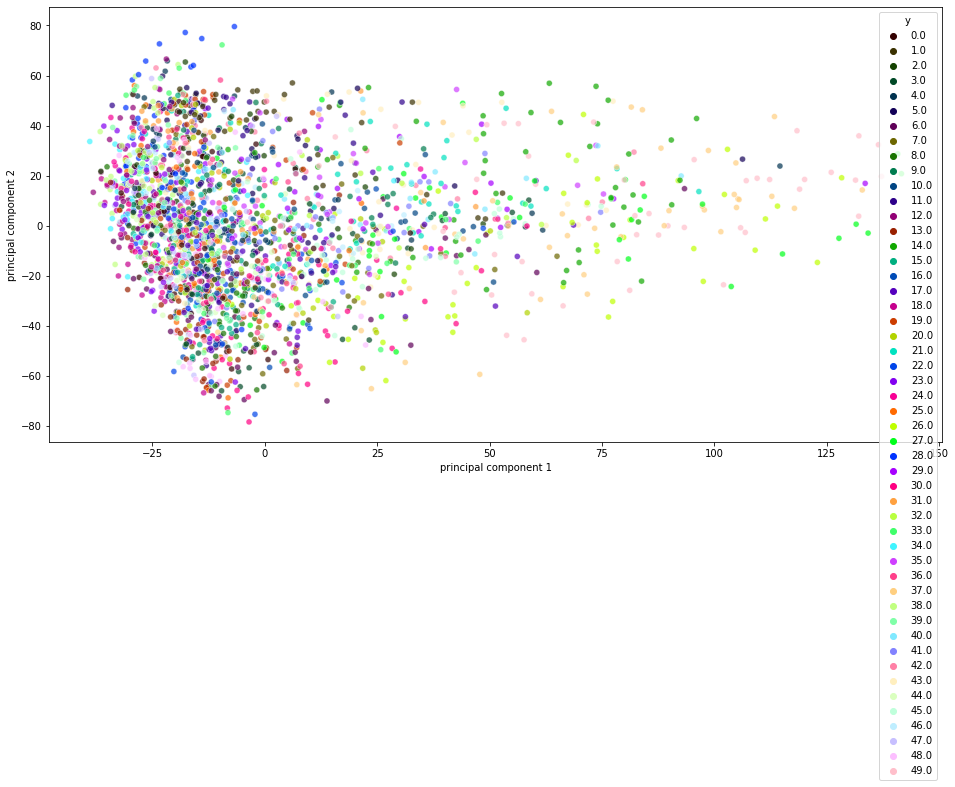

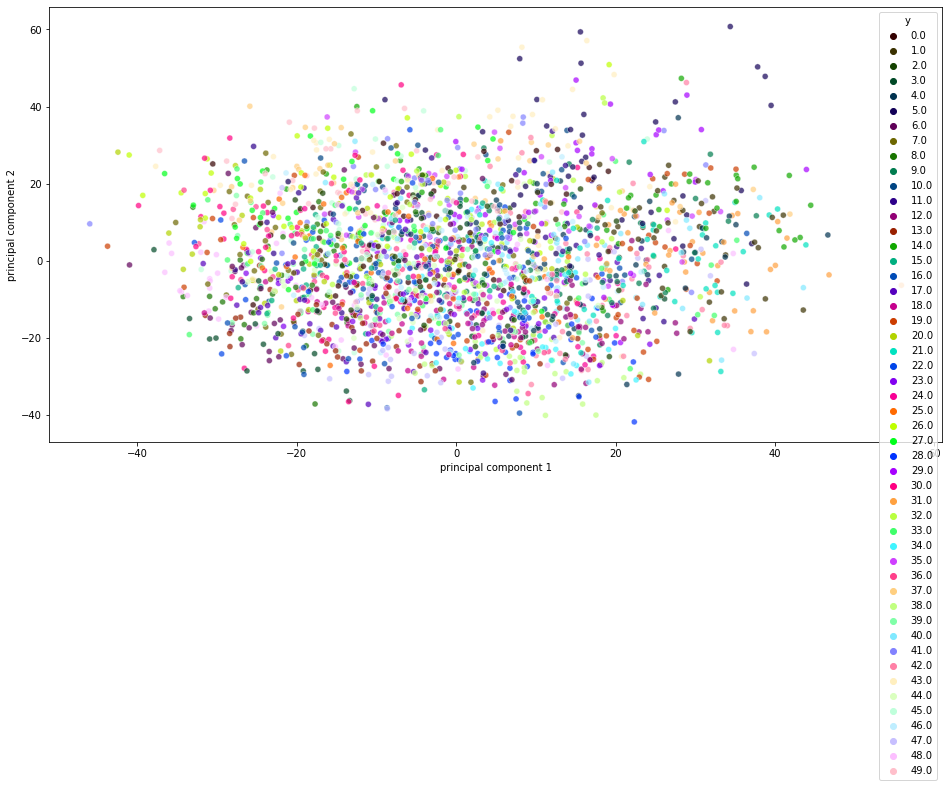

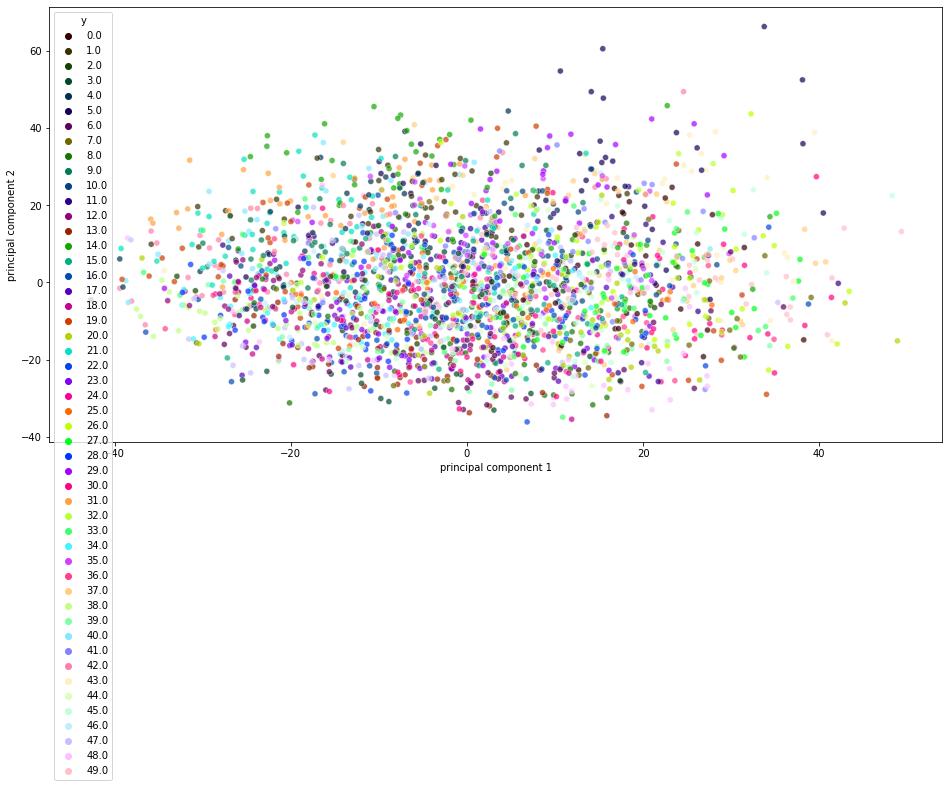

In [ ]:
def getPCA_graph(
    data: torch.Tensor, label: torch.Tensor, n_components: int = 2, epoch: int = 0
) -> None:
    data = data.cpu().detach().numpy()
    label = label.cpu().detach().numpy()
    data = data.reshape(len(data), 512*4*4)
    feat_cols = ["pixel" + str(i) for i in range(data.shape[1])]
    df_cifar = pd.DataFrame(data, columns=feat_cols)
    df_cifar.head()
    print("Size of the dataframe: {}".format(df_cifar.shape))
    pca_cifar = PCA(n_components=2)
    principalComponents_cifar = pca_cifar.fit_transform(df_cifar.iloc[:, :-1])

    principal_cifar_Df = pd.DataFrame(
        data=principalComponents_cifar,
        columns=["principal component 1", "principal component 2"],
    )

    principal_cifar_Df["y"] = label
    principal_cifar_Df.head()
    # print(principal_cifar_Df)
    # input()

    plt.figure(figsize=(16, 8))
    n_colors = len(np.unique(label))
    # print(myset)
    sns.scatterplot(
        x="principal component 1",
        y="principal component 2",
        hue="y",
        palette=generate_colormap(),
        data=principal_cifar_Df,
        legend="full",
        alpha=0.7,
    )
    plt.savefig(f"./drive/MyDrive/DLCV/hw1-a/pca_{epoch}.png")



def plotPCA(path, epoch: int):
  model.eval()
  model.load_state_dict(
      torch.load(path)
  )

  model.cnn[-1].register_forward_hook(get_activation("secondlast"))

  labels = []
  features = torch.empty((0, 512, 4, 4), dtype=torch.float32).to(device)
  labels = torch.empty(0).to(device)
  for source_data, source_label in tqdm(valid_loader):
      source_data = source_data.to(device)
      source_label = source_label.to(device)
      feature = model(source_data)

      # if want to get output of second last
      feature = activation["secondlast"]
      features = torch.cat((features, feature), 0)
      labels = torch.cat((labels, source_label), 0)

  graph_data = torch.empty(0 , len(valid_set) ,512, 4, 4).to(device)
  graph_label = torch.empty( 0 , len(valid_set)).to(device)
  graph_data = torch.cat((graph_data ,features[None, : ,:, :, :] ), dim = 0)
  graph_label = torch.cat((graph_label ,labels[None, :] ), dim = 0)
  for i in range (len(graph_data)): 
    getPCA_graph(graph_data[i], graph_label[i], epoch = epoch)

workdir = "./drive/MyDrive/DLCV"

plotPCA(os.path.join(workdir, "./hw1-a/cnn_best_0.ckpt"), 0)
plotPCA(os.path.join(workdir, "./hw1-a/cnn_best_50.ckpt"), 50)
plotPCA(os.path.join(workdir, "./hw1-a/cnn_best_99.ckpt"), 99)



  0%|          | 0/79 [00:00<?, ?it/s]

torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512,

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 2500 samples in 1.460s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 21.358369
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.492188
[t-SNE] KL divergence after 1000 iterations: 1.639486


  0%|          | 0/79 [00:00<?, ?it/s]

torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512,

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 2500 samples in 1.416s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 20.226971
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.875015
[t-SNE] KL divergence after 1000 iterations: 2.347856


  0%|          | 0/79 [00:00<?, ?it/s]

torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512, 4, 4])
torch.Size([32, 512,

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 2500 samples in 1.418s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 19.722241
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.975243
[t-SNE] KL divergence after 1000 iterations: 2.459897


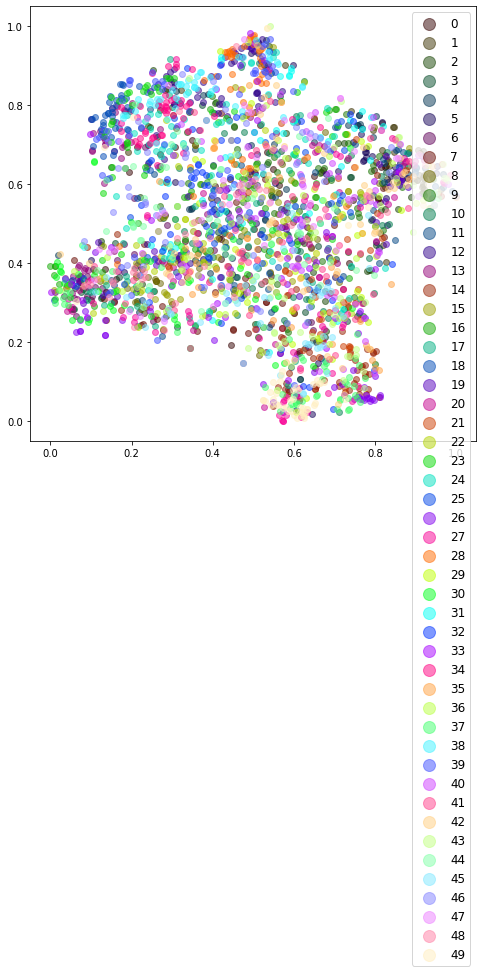

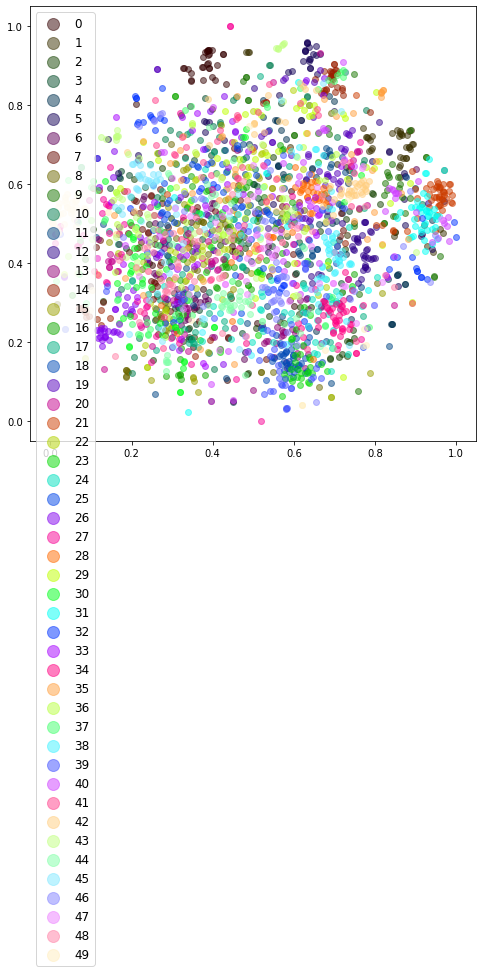

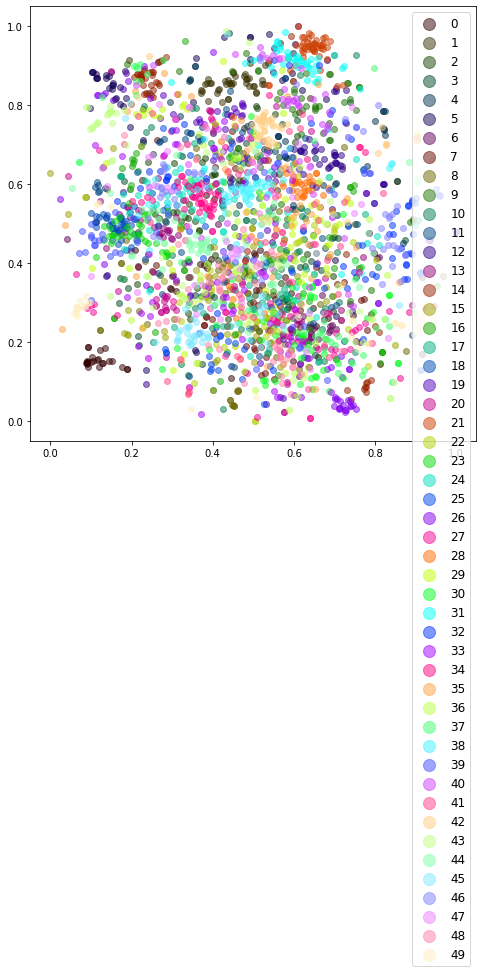

In [ ]:
def report1(path="", epoch = 0):
    """## Step1: Load checkpoint and evaluate to get extracted features"""
    data_dir = "/content/drive/MyDrive/DLCV/"
    # Hints:
    # Set features_extractor to eval mode
    # Start evaluation and collect features and labels
    model.eval()
    model.load_state_dict(
        torch.load(os.path.join(data_dir, path))
    )

    model.cnn[-1].register_forward_hook(get_activation("secondlast"))

    labels = []
    features = torch.zeros((0, 512,4,4), dtype=torch.float32)
    for source_data, source_label in tqdm(valid_loader):
        source_data = source_data.to(device)
        feature = model(source_data)
        # labels.append(source_label)

        labels.extend(source_label.tolist())
        # if want to get output of second last
        feature = activation["secondlast"]
        print(feature.shape)
        features = torch.cat((features, feature.detach().cpu()), 0)
    features = np.array(features)
    print(len(valid_loader))
    features = features.reshape(2500, 512*4*4)
    labels = np.array(labels)
    # print(features.shape)

    """## Step2: Apply t-SNE and normalize"""

    # process extracted features with t-SNE
    X_tsne = manifold.TSNE(
        n_components=2, init="random", random_state=5, verbose=1
    ).fit_transform(features)

    # Normalization the processed features
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne - x_min) / (x_max - x_min)

    """## Step3: Visualization with matplotlib"""

    # Data Visualization
    # Use matplotlib to plot the distribution
    # The shape of X_norm is (N,2)
    # cmap = plt.cm.get_cmap("Spectral")
    cmap = generate_colormap()
    fig, ax = plt.subplots(figsize=(8, 8))
    num_categories = 50
    for lab in range(num_categories):
        indices = labels == lab
        # print(indices)
        ax.scatter(
            X_norm[indices, 0],
            X_norm[indices, 1],
            c=np.array(cmap(lab)).reshape(1, 4),
            label=lab,
            alpha=0.5,
        )
    ax.legend(fontsize="large", markerscale=2)
    plt.savefig(f"./drive/MyDrive/DLCV/tsne_{epoch}.png")
report1("./hw1-a/cnn_best_0.ckpt", epoch = 0)
report1("./hw1-a/cnn_best_50.ckpt", epoch = 50)
report1("./hw1-a/cnn_best_99.ckpt", epoch = 99)
